In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Setting up local directories
DIRs_TO_CREATE = ["figures", "results", "temp"]
        
#Directories for outputs
DIRs_TO_CREATE.extend(["../data-processed/DyLNet/"])

for directory in DIRs_TO_CREATE:
    if not os.path.exists(directory):
        os.makedirs(directory)

## First preprocessing consists in merging all the files together, selecting the relevant features

`Type of interaction`
Since there is a distinction between free-time and class-time for each class-group, we annotated each event with four state labels and a binary flag, SSSSF. State labels take values F, C indicating free- and class-time respectively. The binary flag X indicates whether i, j are from the same class or not. For example, a label FCFC1 would refer to an interaction between two children i and j, belonging to the same class (indicated by 1 at the end of the label), where both of them were in free- time when the interaction event started, but they were in class at the end of the interaction event.

`Duration`
Resolution is in 5 seconds. However, since there was no central unit synchronizing the clock of each badge (they were sync only once per a day), there is some deviation from the modulo 5 sec in terms of starting times.

In [2]:
ROOT_DIR = "../data-raw/DyLNet/"

#Creating a fake ID for the weeks
WEEKS = [1,2,3,4,5,6,7,8,9,10]
# Y_WEEKXX, where Y= academic year (1: first semester, 2: second semester), XX is the week
WEEK_FILENAMES = ["1_WEEK39/","1_WEEK41/","1_WEEK46/","1_WEEK50/",
                 "2_WEEK03/","2_WEEK06/","2_WEEK11/","2_WEEK14/","2_WEEK20/","2_WEEK25/"]
WEEK_DIR = {w:fn for w, fn in zip(WEEKS, WEEK_FILENAMES)}

DIR_TNETS = "HD_tnet_reconstructed/"

DAYS = [1,2,3,4,5]
DAYS_MA = ["M","A"] #morning/afternoon

contexts = ["in-class","out-of-class"]
context_labels= {"in-class":["CCCC1"], "out-of-class":["FFFF1", "FFFF0"]}

Parsing and merging everything in a single dataframe but adding the extra info that are contained in the filenames

In [5]:
dfs=[]

for week in WEEKS:
    for day in DAYS:
        for ma in DAYS_MA:
            for context in contexts:
                FNAME = ROOT_DIR+WEEK_DIR[week]+DIR_TNETS+"%i-%s-blstm_RSSI.csv"%(day, ma)
                cnames = ['timestamp', 'user_a', 'user_b', 'duration', 'interaction_type']
                
                try:
                    df = pd.read_csv(FNAME, names=cnames)
                except FileNotFoundError: #The record of this day is missing
                    continue
                    
                #Filtering on selected interaction types
                df = df[df['interaction_type'].isin(context_labels[context])]
                #I don't need this column anymore
                df.drop('interaction_type', axis=1, inplace=True)
                
                #Adding info I used for filtering
                df['week']=week
                df['day']=day
                df['morning-afternoon']={'M':'morning','A':'afternoon'}[ma]
                df['context']=context
                
                dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)
df.head()

,timestamp,user_a,user_b,duration,week,day,morning-afternoon,context
0,24215398,45,140,60,1,1,morning,in-class
1,24215398,46,51,25,1,1,morning,in-class
2,24215399,11,206,25,1,1,morning,in-class
3,24215399,116,125,5,1,1,morning,in-class
4,24215399,62,83,5,1,1,morning,in-class


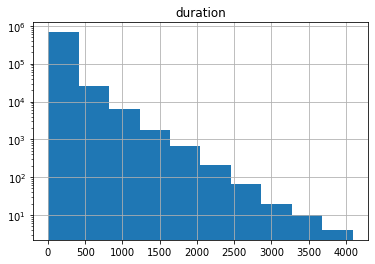

In [8]:
df.hist('duration')
plt.yscale('log')

## Further cleaning
I will remove:
* Teachers from the dataset
* in-class interactions (so during class time) between kids that belong to different classes
* Interactions that last for less than 10 seconds (so the 5s in the dataset)

In [9]:
#Removing adults (IDs>=1000)
print(len(df))
df = df[(df['user_a']<1000)&(df['user_b']<1000)]
print(len(df))

717952
592545


To remove in-class interactions across different classes I import the dataset that contains the information we need

In [10]:
info = pd.read_csv(ROOT_DIR+'SOCIODEMOLING/SocioDemoLing_Data.csv', sep=';')
info.set_index('ID', inplace=True)
info.head()

,age_class,grade,class,tests_P1,tests_P2,age_in_months,sex,birth_rank,siblings,childminder,...,test_P2_period,test_P2_version,test_P2_age_in_months,test_P2_vocA_10,test_P2_vocT_30,test_P2_voc_40,test_P2_memory_span,test_P2_syntA_10,test_P2_syntT_10,test_P2_synt_20
ID,,,,,,,,,,,,,,,,,,,,,
1,child,3rd,5,P1,P2,56.0,M,younger,3.0,no,...,P2.1,endG3,73.0,9.0,18.0,27.0,3.0,8.0,7.0,15.0
4,child,3rd,7,P1,P2,48.0,M,single,1.0,no,...,P2.1,endG3,65.0,10.0,20.0,30.0,6.0,8.0,8.0,16.0
7,child,3rd,7,P1,NaN,50.0,F,younger,2.0,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,child,3rd,7,P1,P2,57.0,M,younger,2.0,yes,...,P2.1,endG3,74.0,10.0,19.0,29.0,3.0,9.0,3.0,12.0
11,child,3rd,6,P1,P2,52.0,F,eldest,2.0,no,...,P2.1,endG3,69.0,8.0,19.0,27.0,6.0,8.0,5.0,13.0


In [12]:
def check_same_class(i, j):
    if info.loc[i]['class']==info.loc[j]['class']:
        return True
    else:
        return False

df['same_class'] = df.apply(lambda row: check_same_class(row.user_a, row.user_b), axis=1)
df.head()

,timestamp,user_a,user_b,duration,week,day,morning-afternoon,context,same_class
0,24215398,45,140,60,1,1,morning,in-class,True
1,24215398,46,51,25,1,1,morning,in-class,True
2,24215399,11,206,25,1,1,morning,in-class,True
3,24215399,116,125,5,1,1,morning,in-class,True
4,24215399,62,83,5,1,1,morning,in-class,True


In [13]:
#Finally dropping in-class interactions across classes
print(len(df))
df = df[~((df['context']=='in-class')&(df['same_class']==False))]
print(len(df))
#I don't need this column anymore
df.drop('same_class', axis=1, inplace=True)
df.head()

592545
592545


,timestamp,user_a,user_b,duration,week,day,morning-afternoon,context
0,24215398,45,140,60,1,1,morning,in-class
1,24215398,46,51,25,1,1,morning,in-class
2,24215399,11,206,25,1,1,morning,in-class
3,24215399,116,125,5,1,1,morning,in-class
4,24215399,62,83,5,1,1,morning,in-class


In [14]:
#Finally filtering by duration of interaction
print(len(df))
df = df[df['duration']>=10]
print(len(df))

592545
538267


In [16]:
df.to_csv('temp/DyLNet_processed_step1.csv.gz', index=False, header=True, compression="gzip")

### Changing the structure by unpacking group durations into timesteps

In [18]:
df = pd.read_csv('temp/DyLNet_processed_step1.csv.gz')
df.head()

,timestamp,user_a,user_b,duration,week,day,morning-afternoon,context
0,24215398,45,140,60,1,1,morning,in-class
1,24215398,46,51,25,1,1,morning,in-class
2,24215399,11,206,25,1,1,morning,in-class
3,24215399,23,62,30,1,1,morning,in-class
4,24215399,116,117,10,1,1,morning,in-class


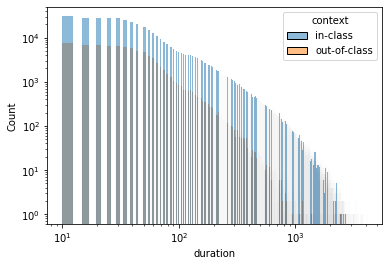

In [19]:
import seaborn as sns

ax =plt.subplot(111)
sns.histplot(data=df, x='duration', hue='context', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')

In [20]:
len(df[df['context']=='in-class']), len(df[df['context']=='out-of-class'])

(449179, 89088)

In [21]:
#First I expand the duration across the rows to generate what is called an 'unbalanced panel' (whaevah)
ext_df = df.loc[df.index.repeat(df.duration)]
#I don't need the `duration` column anymore
ext_df.drop('duration', axis=1, inplace=True)
ext_df.head()

,timestamp,user_a,user_b,week,day,morning-afternoon,context
0,24215398,45,140,1,1,morning,in-class
0,24215398,45,140,1,1,morning,in-class
0,24215398,45,140,1,1,morning,in-class
0,24215398,45,140,1,1,morning,in-class
0,24215398,45,140,1,1,morning,in-class


In [22]:
#Now I need to fix the timestamp adding the increments

#I create a temporary column of increments based on the index (which is not unique anymore, but denotes groups of rows)
ext_df['increment'] = ext_df.groupby(ext_df.index).timestamp.cumcount() 
#Then I add the increment to the timestamp column
ext_df['timestamp'] = ext_df['timestamp']+ext_df['increment']
#I don't need the `increment` column anymore
ext_df.drop('increment', axis=1, inplace=True)
#Fixing the index
ext_df = ext_df.reset_index(drop=True)
ext_df.head()

,timestamp,user_a,user_b,week,day,morning-afternoon,context
0,24215398,45,140,1,1,morning,in-class
1,24215399,45,140,1,1,morning,in-class
2,24215400,45,140,1,1,morning,in-class
3,24215401,45,140,1,1,morning,in-class
4,24215402,45,140,1,1,morning,in-class


In [ ]:
ext_df.to_csv('temp/DyLNet_processed_step2.csv.gz', index=False, header=True, compression="gzip")

## Temporal aggregation

In [24]:
df = pd.read_csv('temp/DyLNet_processed_step2.csv.gz')
df.head()

,timestamp,user_a,user_b,week,day,morning-afternoon,context
0,24215398,45,140,1,1,morning,in-class
1,24215399,45,140,1,1,morning,in-class
2,24215400,45,140,1,1,morning,in-class
3,24215401,45,140,1,1,morning,in-class
4,24215402,45,140,1,1,morning,in-class


In [ ]:
window_sampling=10 #seconds

df['agg_timestamp'] = df.apply(lambda row: round(row.timestamp/window_sampling), axis=1)

In [80]:
df.drop('timestamp', axis=1, inplace=True)
df.rename(columns={"agg_timestamp": "timestamp"}, inplace=True)
df.head()

,user_a,user_b,week,day,morning-afternoon,context,timestamp
0,45,140,1,1,morning,in-class,2421540
1,45,140,1,1,morning,in-class,2421540
2,45,140,1,1,morning,in-class,2421540
3,45,140,1,1,morning,in-class,2421540
4,45,140,1,1,morning,in-class,2421540


The temporal aggregation inevitably generated duplicates

In [81]:
df.drop_duplicates(inplace=True)
df.head()

,user_a,user_b,week,day,morning-afternoon,context,timestamp
0,45,140,1,1,morning,in-class,2421540
8,45,140,1,1,morning,in-class,2421541
17,45,140,1,1,morning,in-class,2421542
28,45,140,1,1,morning,in-class,2421543
37,45,140,1,1,morning,in-class,2421544


In [82]:
df.to_csv('temp/DyLNet_processed_step3_%i_sec.csv.gz'%window_sampling, index=False, header=True, compression="gzip")

## Adding isolated nodes
I will use the same approach of the other dataset, by denoting isolated nodes as interactions with phatom node -1

In [18]:
window_sampling=10 #seconds
df = pd.read_csv('temp/DyLNet_processed_step3_%i_sec.csv.gz'%window_sampling)
df.head()

,user_a,user_b,week,day,morning-afternoon,context,timestamp
0,45,140,1,1,morning,in-class,2421540
1,45,140,1,1,morning,in-class,2421541
2,45,140,1,1,morning,in-class,2421542
3,45,140,1,1,morning,in-class,2421543
4,45,140,1,1,morning,in-class,2421544


In [19]:
#New entries containing the isolated nodes that I will append at the end
entries_to_add = []

for week in df['week'].unique():
    print(week)
    for day in df['day'].unique():
        print(day)
        for ma in df['morning-afternoon'].unique():
            for context in df['context'].unique():
                dfx = df[(df['week']==week)&(df['day']==day)&(df['morning-afternoon']==ma)&(df['context']==context)]
                #Set of active nodes in this period of time
                active_nodes = set(dfx['user_a'].unique()).union(set(dfx['user_b'].unique()))
                
                #For each timestep in the selected period...
                for t in dfx['timestamp'].unique():
                    dfx_t = dfx[dfx['timestamp']==t]
                    #Set of active nodes at t
                    active_nodes_t = set(dfx_t['user_a'].unique()).union(set(dfx_t['user_b'].unique()))
                    #Computing the isolated nodes at t
                    isolated_nodes_t = active_nodes.difference(active_nodes_t)
                    #Adding to entries
                    for iso_t in isolated_nodes_t:
                        entries_to_add.append([iso_t, -1, week, day, ma, context, t])

1
1
2
3
4
5
2
1
2
3
4
5
3
1
2
3
4
5
4
1
2
3
4
5
5
1
2
3
4
5
6
1
2
3
4
5
7
1
2
3
4
5
8
1
2
3
4
5
9
1
2
3
4
5
10
1
2
3
4
5


In [20]:
df_isolates = pd.DataFrame(columns=['user_a','user_b','week','day','morning-afternoon','context','timestamp'],
                           data=entries_to_add)
df_isolates.head()

,user_a,user_b,week,day,morning-afternoon,context,timestamp
0,1,-1,1,1,morning,in-class,2421540
1,4,-1,1,1,morning,in-class,2421540
2,7,-1,1,1,morning,in-class,2421540
3,14,-1,1,1,morning,in-class,2421540
4,16,-1,1,1,morning,in-class,2421540


In [21]:
df_with_isolates = pd.concat([df, df_isolates], ignore_index=True)
df_with_isolates.head()

,user_a,user_b,week,day,morning-afternoon,context,timestamp
0,45,140,1,1,morning,in-class,2421540
1,45,140,1,1,morning,in-class,2421541
2,45,140,1,1,morning,in-class,2421542
3,45,140,1,1,morning,in-class,2421543
4,45,140,1,1,morning,in-class,2421544


In [22]:
df_with_isolates.to_csv('../data-processed/DyLNet/DyLNet_processed.csv.gz', index=False, header=True, compression="gzip")

In [2]:
puppa = pd.read_csv('../data-processed/DyLNet/DyLNet_processed.csv.gz')